In [1]:
import cv2
import numpy as np
import glob
from matplotlib import pyplot as plt

In [2]:
SIFT_method = False

Questa funzione prende in ingresso l'immagine originale, l'immagine ritagliata e il nome del salvataggio. Restituisce un immagine che rappresenta la zona di lavoro

In [3]:
def cutWorkSpace(img,border): 
    # dimensioni immagini
    img_h = 2048
    img_l = 2048
    # offset per posizionamento su area d'indagine
    offset_x = 600
    offset_y = 500
    
    #taglio per garantire la ricerca sull'area di interesse, evitando rumori dati dallo sfondo
    crop_img = img[offset_y:img_h-offset_y, offset_x:img_l-offset_x]
    
    # Convert the img to grayscale
    gray = cv2.cvtColor(crop_img,cv2.COLOR_BGR2GRAY)
    blurred = cv2.GaussianBlur(gray, (9, 9), 0)
    high_thresh, thresh_im = cv2.threshold(blurred, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    #cv2.imwrite('provaT.jpg', thresh_im)
    lowThresh = 0.5*high_thresh
    
    
    # Apply edge detection method on the image
    #edges = cv2.Canny(blurred,20,150,apertureSize = 3)
    edges = cv2.Canny(blurred,20,150,apertureSize = 3)
    cv2.imwrite('canny.jpg', edges)
    # This returns an array of r and theta values
    lines = cv2.HoughLines(edges,1,np.pi/180, 100)
    #cv2.imwrite('Risultati/resFS'+name+'c.jpg', edges)
    # The below for loop runs till r and theta values 
    # are in the range of the 2d array
    i = 0
    x_first = 0
    x_second = 0
    count = 0
    delta = 30

    while count < 2:
        for r,theta in lines[i]:
            # Stores the value of cos(theta) in a
            a = np.cos(theta)

            # Stores the value of sin(theta) in b
            b = np.sin(theta)

            # x0 stores the value rcos(theta)
            x0 = a*r

            # y0 stores the value rsin(theta)
            y0 = b*r

            #ti define line lenght
            const = 3000
            # x1 stores the rounded off value of (rcos(theta)-1000sin(theta))
            x1 = int(x0 + const*(-b))

            # y1 stores the rounded off value of (rsin(theta)+1000cos(theta))
            y1 = int(y0 + const*(a))

            # x2 stores the rounded off value of (rcos(theta)+1000sin(theta))
            x2 = int(x0 - const*(-b))

            # y2 stores the rounded off value of (rsin(theta)-1000cos(theta))
            y2 = int(y0 - const*(a))

            if count == 0 :
                
                x_first = x0
                #cv2.line(img,(x1+offset_x,y1+offset_y), (x2+offset_x,y2+offset_y), (0,0,255),2)
                count += 1
            else:
                if abs(x_first-x0) > delta :
                    x_second = x0
                    #cv2.line(img,(x1+offset_x,y1+offset_y), (x2+offset_x,y2+offset_y), (0,0,255),2)
                    count += 1
            i += 1
    # All the changes made in the input image are finally
    # written on a new image houghlines.jpg
    #cv2.imwrite('Risultati/res'+name+'.jpg', img)
    
    if x_first < x_second:
        temp = img[0:img_h-1, int(offset_x+x_first-border):int(offset_x+x_second+border)]
        #blurred = cv2.GaussianBlur(temp, (3,3), 0)
        return  temp
    else:
        temp = img[0:img_h-1, int(offset_x+x_second-border):int(offset_x+x_first+border)]
        #blurred = cv2.GaussianBlur(temp, (3,3), 0)
        return  temp

In [4]:
def divideImage(img,pcs):
    results = []
    lung = len(img) // pcs
    for i in range(pcs):
        results.append(img[(lung*i):(lung*(i+1)-1)][:])

    return results

## Creazione histogramma usando features - creazione NN
accetta in ingresso un vettore con [[img],[classe]]
in uscita mi ritorna kmeans e MLP

In [5]:
from sklearn.cluster import MiniBatchKMeans
from sklearn.neural_network import MLPClassifier

def createNN(imgsWithClass, Nclusters):
    if SIFT_method:
        sift = cv2.xfeatures2d.SIFT_create()
    else:
        orb = cv2.ORB_create()   
    results = imgsWithClass[0]

    keypoints = []
    descriptors = []
    dico = []
    for img in results:
        if SIFT_method:
            keypoints_temp, descriptors_temp = sift.detectAndCompute(img, None)
        else:    
            keypoints_temp, descriptors_temp = orb.detectAndCompute(img, None)
        keypoints.append(keypoints_temp)
        descriptors.append(descriptors_temp)
        for d in descriptors_temp:
            dico.append(d)        
    k = Nclusters
    batch_size = 256*4
    kmeans = MiniBatchKMeans(n_clusters=k, batch_size=batch_size, verbose=1).fit(dico)
    
    length = len(results)

    train_index = length - 1 
    train_imgs = results[:train_index]
    validation_imgs = results[train_index:]
    
    # creo histogramma con valori trovati di feature per ogni immagine di train
    kmeans.verbose = False
    histo_list = []

    for img in train_imgs:
        if SIFT_method:
            kp, des = sift.detectAndCompute(img, None)
        else:
            kp, des = orb.detectAndCompute(img,None)
        histo = np.zeros(k)
        nkp = np.size(kp)

        for d in des:
            idx = kmeans.predict([d])
            histo[idx] += 1/nkp # Because we need normalized histograms, I prefere to add 1/nkp directly

        histo_list.append(histo)
    #creo X_train e Y_train
    X_train = np.array(histo_list) 
    print(len(X_train))
    Y_train = imgsWithClass[1][:train_index]
    mlp = MLPClassifier(verbose=True, max_iter=600000,hidden_layer_sizes=1000, alpha=0.0001, n_iter_no_change=10)
    mlp.fit(X_train, Y_train)
    
    Y_val = imgsWithClass[1][train_index:]
    val_result = []
    i = 0 
    for img in validation_imgs:
        if SIFT_method:
            kp, des = sift.detectAndCompute(img, None)
        else:
            kp, des = orb.detectAndCompute(img,None)
        x = np.zeros(k)
        nkp = np.size(kp)
        for d in des:
            idx = kmeans.predict([d])
            x[idx] += 1/nkp #ottengo vettore normalizzato da kmeans
        res = mlp.predict_proba([x])
        row = []
        # predico. salvo probabilità classificazione e unisco risultato vero per verifica
        for e in res[0]:
            row.append(e)
        if row[0] < row[1]:
            val_result.append([row,Y_val[i],"Scarto"])
        else:
            val_result.append([row,Y_val[i]])
        i += 1
    
    return kmeans, mlp, val_result

Creo funzione per testare immagini sulla NN trovata

In [6]:
def testNN(img_test,border,pcs,Nclusters):
    img = cutWorkSpace(img_test,border)
    imgs = divideImage(img,pcs)
    if SIFT_method:
        sift = cv2.xfeatures2d.SIFT_create()
    else:
        orb = cv2.ORB_create()   

    k = Nclusters
    results = []
    for img in imgs:
        if SIFT_method:
            kp, des = sift.detectAndCompute(img, None)
        else:
            kp, des = orb.detectAndCompute(img,None)
        x = np.zeros(k)
        nkp = np.size(kp)
        for d in des:
            idx = kmeans.predict([d])
            x[idx] += 1/nkp #ottengo vettore normalizzato da kmeans
        results.append(mlp.predict_proba([x])[0])

        
    return results

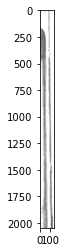

In [7]:
pathBuoni = '/Users/leonardoaggio/Desktop/Dataset/S606C/Buoni70/*.tif'
pathBuoni = '/Users/leonardoaggio/Desktop/Dataset/S606C/Buoni100/*.tif'
#pathBuoni = '/Users/leonardoaggio/Desktop/Dataset/S606C/Buoni120/*.tif'

pathFS = '/Users/leonardoaggio/Desktop/Dataset/S606C/FalsiScarti/*.tif'
pathScarti = '/Users/leonardoaggio/Desktop/Dataset/S606C/Scarti/*.tif'

pathBuoniVal = '/Users/leonardoaggio/Desktop/Dataset/S606C/Buoni70Val/*.tif'
pathBuoniVal = '/Users/leonardoaggio/Desktop/Dataset/S606C/Buoni100Val/*.tif'
#pathBuoniVal = '/Users/leonardoaggio/Desktop/Dataset/S606C/Buoni120Val/*.tif'

pathFSVal = '/Users/leonardoaggio/Desktop/Dataset/S606C/FalsiScartiVal/*.tif'
pathScartiVal = '/Users/leonardoaggio/Desktop/Dataset/S606C/ScartiVal/*.tif'

pezziXimmagine = 1
border = 50
Nclusters = 30

results = []
img_results = []
list_paths = []

list_paths += glob.glob(pathScarti)
results += [1] * len(glob.glob(pathScarti)) * pezziXimmagine

list_paths += glob.glob(pathBuoni) 
results += [0] * len(glob.glob(pathBuoni)) * pezziXimmagine

#list_paths += glob.glob(pathFS)
#results += [0] * len(glob.glob(pathFS)) * pezziXimmagine


#list_paths += glob.glob(pathBuoniVal) 
#results += [0] * len(glob.glob(pathBuoniVal)) * pezziXimmagine

#list_paths += glob.glob(pathFSVal)
#results += [0] * len(glob.glob(pathFSVal)) * pezziXimmagine

#list_paths += glob.glob(pathScartiVal)
#results += [1] * len(glob.glob(pathScartiVal)) * pezziXimmagine



#print(results)
i = 0
for img_path in list_paths:
    img = cv2.imread(img_path)
    temp = cutWorkSpace(img,border)
    #cv2.imwrite('ImgScarte/img'+str(i)+'.jpg', temp)
    temp2 = divideImage(temp,pezziXimmagine)
    img_results += temp2
    j = 0
    for im in temp2:
        #cv2.imwrite('ImgScarte/img'+str(i)+'pzs'+str(j)+'.jpg', im)
        j += 1
    i += 1


        

#####
# ORA HO IMG_RESULTS & RESULTS
plt.imshow(img_results[10])
plt.show()

In [8]:
imgsWithClass = [img_results,results]


kmeans, mlp, val_result = createNN(imgsWithClass, Nclusters)

Init 1/3 with method: k-means++
Inertia for init 1/3: 258085215.250590
Init 2/3 with method: k-means++
Inertia for init 2/3: 258756633.170194
Init 3/3 with method: k-means++
Inertia for init 3/3: 257358239.664296
Minibatch iteration 1/3800: mean batch inertia: 85664.573249, ewa inertia: 85664.573249 
Minibatch iteration 2/3800: mean batch inertia: 85339.676084, ewa inertia: 85647.205599 
Minibatch iteration 3/3800: mean batch inertia: 86982.284744, ewa inertia: 85718.573371 
Minibatch iteration 4/3800: mean batch inertia: 86453.253523, ewa inertia: 85757.846313 
Minibatch iteration 5/3800: mean batch inertia: 82556.965947, ewa inertia: 85586.740576 
Minibatch iteration 6/3800: mean batch inertia: 83628.629283, ewa inertia: 85482.068100 
Minibatch iteration 7/3800: mean batch inertia: 79814.114682, ewa inertia: 85179.082910 
Minibatch iteration 8/3800: mean batch inertia: 85044.925916, ewa inertia: 85171.911435 
Minibatch iteration 9/3800: mean batch inertia: 84307.831820, ewa inertia: 

In [9]:
for res in val_result:
    print(res)

[[0.9775349634843763, 0.022465036515623687], 0]


In [10]:
temp = '/Users/leonardoaggio/Desktop/Dataset/S606C/ScartiTotali/*.tif'
temp = pathScarti
i = 0
test_path = glob.glob(temp) 
for img_path in test_path:
    img = cv2.imread(img_path)
    #plt.imshow(img)
    #plt.show()
    try:
        res = testNN(img,border,pezziXimmagine,Nclusters)
        #print(res)
        # 1 se orb, 2 se sift
        if len(res) == 1:
           # print(res[0][0])
           # print(res[0][1])
            if res[0][0] > res [0][1]:
                print(res[0][0])
                print(res[0][1])
                i += 1
        else:
            j = 0
            for count in range(len(res)):
                #print(res[count][0])
                if res[count][0] > res [count][1]:
                    j += 1
            if j == len(res) :
                i+=1
                print('ciao')
    except:
        print('errore nell elaborazione')
print('TRAIN')
print('BUONI : '+ str(i))
print('Falsi buoni su scarti totali: '+ str(i/len(test_path)))

0.562864180924723
0.43713581907527704
0.5019634339748885
0.4980365660251115
TRAIN
BUONI : 2
Falsi buoni su scarti totali: 0.3333333333333333


In [11]:
temp = '/Users/leonardoaggio/Desktop/Dataset/S606C/ScartiTotali/*.tif'
temp = pathScartiVal
i = 0
test_path = glob.glob(temp) 
for img_path in test_path:
    img = cv2.imread(img_path)
   # plt.imshow(img)
    #plt.show()
    try:
        res = testNN(img,border,pezziXimmagine,Nclusters)
        #print(res)
        # 1 se orb, 2 se sift
        if len(res) == 1: 
           # print(res[0][0])
           # print(res[0][1]) 
            if res[0][0] > res [0][1]:
                print(res[0][0])
                print(res[0][1])
                i += 1
        else:
            j = 0
            for count in range(len(res)):
                #print(res[count][0])
                if res[count][0] > res [count][1]:
                    j += 1
            if j == len(res) :
                i+=1
                print('ciao')
                    
    except:
        print('errore nell elaborazione')
print('VALIDATION')

print('BUONI : '+ str(i))
print('Falsi buoni su scarti totali: '+ str(i/len(test_path)))

0.5117838583047685
0.48821614169523153
0.9897745586433347
0.010225441356665293
0.91761864098455
0.08238135901544998
VALIDATION
BUONI : 3
Falsi buoni su scarti totali: 1.0


In [12]:
i = 0
temp = pathBuoniVal
test_path = glob.glob(temp) 
for img_path in test_path:
    img = cv2.imread(img_path)
    #plt.imshow(img)
    #plt.show()
    try:
        res = testNN(img,border,pezziXimmagine,Nclusters)
        # 1 se orb, 2 se sift
        if len(res) == 1:   
            if res[0][0] < res [0][1]:
                i += 1
        else:
            for count in range(len(res)):
                if res[count][0] < res [count][1]:
                    i += 1
                    break
    except:
        print('errore nell elaborazione')
print('SCARTI : '+ str(i))
print('Falsi scarti su buoni: '+ str(i/len(test_path)))

SCARTI : 1
Falsi scarti su buoni: 0.030303030303030304


In [13]:
temp = '/Users/leonardoaggio/Desktop/Dataset/S606C/Cam3@00004/*.tif'
i = 0
j = 0
#temp = pathBuoniVal
test_path = glob.glob(temp) 
for img_path in test_path:
    img = cv2.imread(img_path)
    #plt.imshow(img)
    #plt.show()
    if j % 10 == 0:
        print(str(j)+'/'+str(len(test_path)))
    j = j+1 
    try:
        res = testNN(img,border,pezziXimmagine,Nclusters)
        # 1 se orb, 2 se sift
        if len(res) == 1:   
            if res[0][0] < res [0][1]:
                i += 1
                #plt.imshow(img)
                #plt.show()
                print(img_path)
        else:
            for count in range(len(res)):
                if res[count][0] < res [count][1]:
                    i += 1
                    break
    except:
        print('errore nell elaborazione')
        print(img_path)
print('SCARTI : '+ str(i))
print('Falsi scarti su buoni: '+ str(i/len(test_path)))
print('su '+ str(len(test_path))+' totali')

0/436
10/436
20/436
30/436
40/436
50/436
60/436
70/436
80/436
90/436
100/436
110/436
120/436
130/436
140/436
150/436
160/436
170/436
180/436
190/436
200/436
/Users/leonardoaggio/Desktop/Dataset/S606C/Cam3@00004/61914891151952.tif
210/436
220/436
230/436
240/436
250/436
260/436
270/436
280/436
290/436
300/436
310/436
320/436
330/436
340/436
350/436
/Users/leonardoaggio/Desktop/Dataset/S606C/Cam3@00004/61914891151687.tif
360/436
370/436
380/436
390/436
400/436
410/436
420/436
430/436
SCARTI : 2
Falsi scarti su buoni: 0.0045871559633027525
su 436 totali
